<a href="https://colab.research.google.com/github/aaperei/data-science/blob/main/som_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural Não Supervisionada SOM - Projeto 2
### Alison Augusto Miranda Pereira - UNIFESP - 2021

## Descrição do problema
O presente trabalho tem o objetivo de explorar o algoritmo da rede neural não suervisionada SOM - *Self Organizing Maps*.

Os dados utilizados para treinamento da rede foram importadas através da bibliotca `sklearn`. Foram escolhidos os *datases* `iris`, `breast cancer` e `wine`:
- O *dataset* `iris` compreende a 150 exemplos de características de flores do tipo Iris, compreendendo 4 características avaliadas para as classes `setosa`, `versicolor` e `virginica`.
- O *dataset* `breast cancer` compreende a 568 exemplos de características de tumores benignos e malignos nas mamas, compreendendo 30 atributos avaliados para as classes `benign` e `malignant`.
- O *dataset* `wine` compreende 177 a exemplos de características de vinhos, compreendendo 13 características avaliadas para as classes `class_0`, `class_1` e `class_2`.

A implementação da rede SOM escolhida é a do `miniSOM`. O projeto `miniSOM` encontra-se disponível no *github* através do endereço eletrônico [https://github.com/JustGlowing/minisom](https://github.com/JustGlowing/minisom).


A seguir, vamos importar todos os `datasets` utilizados.

In [86]:
import sklearn.datasets
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

iris = sklearn.datasets.load_iris()
breast_cancer = sklearn.datasets.load_breast_cancer()
wine = sklearn.datasets.load_wine()

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['label'] = [iris.target_names[i] for i in iris.target]
print(df)

df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df['label'] = [breast_cancer.target_names[i] for i in breast_cancer.target]
print(df)

df = pd.DataFrame(wine.data, columns=wine.feature_names)
df['label'] = [wine.target_names[i] for i in wine.target]
print(df)

     sepal length (cm)  sepal width (cm)  ...  petal width (cm)      label
0                  5.1               3.5  ...               0.2     setosa
1                  4.9               3.0  ...               0.2     setosa
2                  4.7               3.2  ...               0.2     setosa
3                  4.6               3.1  ...               0.2     setosa
4                  5.0               3.6  ...               0.2     setosa
..                 ...               ...  ...               ...        ...
145                6.7               3.0  ...               2.3  virginica
146                6.3               2.5  ...               1.9  virginica
147                6.5               3.0  ...               2.0  virginica
148                6.2               3.4  ...               2.3  virginica
149                5.9               3.0  ...               1.8  virginica

[150 rows x 5 columns]
     mean radius  mean texture  ...  worst fractal dimension      label
0   

## Funções auxiliares - Avaliação dos modelos

Para analisarmos o desempenho da rede neural SOM, utilizamos algumas funções retiradas da documentação do MiniSOM.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from plotnine import ggplot, aes, ggtitle, geom_line, ylab, xlab

RANDOM_STATE = 777

np.random.seed(RANDOM_STATE)

""" *** Functions from MiniSOM Docs *** """


def umatrix(som_model, data, labels, colors, markers, classes, use_colorbar=True, plot_lbl_args=None, **kwargs):
    """Plot Labeled U-Matrix """

    if not plot_lbl_args:
        plot_lbl_args = {
            'markerfacecolor': 'None',
            'markersize': 6,
            'markeredgewidth': 1
        }

    im = plt.imshow(som_model.distance_map(), **kwargs)
    if use_colorbar:
        plt.colorbar(im)

    for idx, de in enumerate(data):
        label_idx = labels[idx] - 1

        winner = som_model.winner(de)
        plt.plot(winner[1], winner[0],
                 markers[label_idx],
                 markeredgecolor=colors[label_idx],
                 **plot_lbl_args)
    legend_elements = []
    colors = [(0, 0, 0, 1), (0.118, 0.565, 1, 1), (0.749, 1, 0, 1)]
    if len(classes) > 2:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markeredgecolor=colors[0], markersize=10))
        legend_elements.append(
            Line2D([0], [0], marker='s', color='w', markeredgecolor=colors[1], markersize=10))
        legend_elements.append(
            Line2D([0], [0], marker='D', color='w', markeredgecolor=colors[2], markersize=10))
    else:
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markeredgecolor=colors[0], markersize=10))
        legend_elements.append(
            Line2D([0], [0], marker='D', color='w', markeredgecolor=colors[2], markersize=10))

    plt.legend(legend_elements, classes, bbox_to_anchor=(0.8, -0.1))


def hitmap(som_model, data, use_colorbar=True, transpose=False, **kwargs):
    """Plot Self-organizing map hitmap"""
    frequencies = som_model.activation_response(data).astype(int)

    if transpose:
        frequencies = frequencies.T[::-1]

    im = plt.imshow(frequencies, **kwargs)
    if use_colorbar:
        plt.colorbar(im)

    for (i, j), value in np.ndenumerate(frequencies):
        plt.text(j, i, value, verticalalignment='center',
                 horizontalalignment='center')


def heatmap(som_model, feature_names, grid_spec, use_colorbar=True, **kwargs):
    """Plot Self-organizing map heatmap"""

    font_size = 10

    if(len(feature_names)>10):
      font_size=5
    

    weights = som_model.get_weights()

    for i, fname in enumerate(feature_names):
        plt.subplot(*grid_spec, i + 1)
        plt.title(fname, fontsize=font_size)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
       
        im = plt.imshow(weights[:, :, i], **kwargs)

        if use_colorbar:
            cbar = plt.colorbar(im)
            cbar.ax.tick_params(labelsize=font_size)
        plt.subplots_adjust(hspace=1.5)


def generate_errors(som_model, data, max_iter):
    """Generate the errors for SOM model

    Reference: https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """

    errors = {
        'qtf_error': [],
        'tpg_error': []
    }

    for idx in range(max_iter):
        data_random = data[np.random.randint(len(data))]

        som_model.update(data_random, som_model.winner(data_random), idx, max_iter)

        errors['qtf_error'].append(som_model.quantization_error(data))
        errors['tpg_error'].append(som_model.topographic_error(data))
    return pd.DataFrame(errors)


def plot_som_maps(som_model, data, w, h, labels, colors, markers, classes, **kwargs):
    """ Plot U-Matrix, Hitmap and Heatmaps

    Reference: https://www.kaggle.com/phelpsmemo/cap-351-neurocomputacao-projeto2-som"""

    def plot_heat_map_som(som_model, data, **kwargs):

        plt.figure(**kwargs)
        heatmap(som_model, data.feature_names, (w, h), cmap='brg')
        plt.suptitle('Heatmap')

        plt.show()

    plt.figure(**kwargs)

    plt.subplot(2, 2, 1)
    umatrix(som_model, data.data, labels, colors, markers, classes, cmap='Reds')
    plt.title('U-Matrix')

    plt.subplot(2, 2, 2)
    hitmap(som_model, data.data, cmap='Reds')
    plt.title('Hitmap (Frequencies)')

    plt.show()
    plot_heat_map_som(som_model, data, **kwargs)


def plot_learning_rate(som, learning_rates, data, grid, n_class):
    """Plot results from different learning rates

    Reference: https://github.com/JustGlowing/minisom/blob/master/examples/BasicUsage.ipynb
    """

    models = {}
    results = []
    for lr in learning_rates:

        lr_error = generate_errors(som, data, 1000)

        lr_error['label'] = lr
        lr_error['label'] = pd.Categorical(lr_error['label']).astype(str)

        models[lr] = som

        results.append(lr_error)
    df_lr = pd.concat(results)

    g = ggplot(df_lr, aes(x='df_lr.index', y='qtf_error', color='label')) +\
        geom_line() + xlab("Iterations") + ylab("Quantization Error") + \
        ggtitle("Quantization Error x Learning Rate")

    g.draw()
    g = ggplot(df_lr, aes(x='df_lr.index', y='tpg_error', color='label')) +\
        geom_line() + xlab("Iterations") + ylab("Topographic Error") +\
        ggtitle("Topographic Error x Learning Rate")
    g.draw()
    plt.show()

## Treinamento da rede SOM

O código a seguir exemplifica como é feito o treinamento da rede SOM por meio da biblioteca `miniSOM`:

```
from minisom import MiniSom    
som = MiniSom(6, 6, 4, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train(data, 100) # trains the SOM with 100 iterations
```

Também podemos fazer uso do método `som.train_random(data, 100)`, que vai escolhendo as amostras de treinamento de uma forma aleatória.

## Configurações realizadas
Os experimentos foram construídos com a combinação dos valores de Grade com a Taxa de Aprendizado padrão (0.001) e com a variação da Taxa de Aprendizado. No total, foram realizados 18 experimentos para a variação da Taxa de Aprendizado e 3 para a variação da Grade, totalizando 21 experimentos por *dataset*. Para cada experimento foram considerados como métricas os resultados de Erro Topográfico e Erro de Quantização, ambos em relação às variações na Taxa de Aprendizado de 18 experimentos. No caso dos três últimos experimentos, em que a taxa de aprendizado foi mantida, foram considerados a *U-Matrix*, o *Hitmap* e o *Heatmap*. 
- Variação no tamanho da grade: 6x6, 12x12 e 18x18
- Variação da taxa de aprendizado: 0.001, 0.01, 0.2, 0.4, 0.8 e 1.0
- Treinamento com 1000 iterações


In [88]:
number_of_epochs = 1000
grid = [6, 12, 18]
lr = [0.001, 0.01, 0.2, 0.4, 0.8, 1.0]

## Trainamento da Rede SOM - *Dataset* `Breast Cancer`

A seguir apresentamos o treinamento e a avaliação de desempenho da rede SOM, utilizando o dataset `breast cancer`, em diversas configurações.

### Grade 6x6
Com a grade 6 x 6, temos resultados bem confusos no delineamento das classes representadas pela *U-Matrix*. No caso do *Hitmap*, foi mostrado pouca presença de frequências baixas (inferior a 5), tornando difícil a separação dos *clusters*. Isso se deve ao fato das frequências baixas funcionarem como uma zona de fronteira (delimitação) entre os diferentes *clusters*.

Comparando os *Heatmaps* com a *U-Matrix*, no geral houve boa divisão nas partes sem aglomeração dos tipos de tumores, com uma certa variação nas áreas onde as classes estão aglomeradas.

Ambos os erros apresentaram variação muito alta em relação à taxa de aprendizagem. Isso é devido provavelmente ao tamanho da grade em relação à quantidade exemplos avaliados. Ao fim do treinamento, a taxa de aprendizagem `0.2` apresentou o menor erro de quantização e a taxa de aprendizagem `0.4` o menor erro topografico.
### Grade 12x12

Com a grade 12 x 12, houve uma grande melhora no delineamento das classes representadas pela *U-Matrix*. No caso do *Hitmap*, foi mostrada o aparecimento de clusters mais definidos.

Comparando os *Heatmaps* com a *U-Matrix*, novamente houve boa divisão nas partes sem aglomeração dos tipos de tumores, com uma certa variação nas áreas onde as classes estão aglomeradas.

O erro topográfico continuou com variação muito alta em relação à taxa de aprendizagem, enquanto o erro de quantização foi suavizado. As taxas de aprendizagem `0.8` e `0.01` apresentaram o melhor decaimento para o erro de quantização, enquanto a taxa de aprendizagem `1.0` apresentou o melhor decaimento para o erro topográfico.

### Grade 18x18

Com a grade 18 x 18, houve uma piora no resultado de delineamento das classes, pois houve o surgimento de novos *clusters*, como mostrados pela *U-Matrix*. No caso do *Hitmap*, apesar do aparecimento de novos clusters, estão menos definidos que na grade 12 x 12.

Comparando os *Heatmaps* com a *U-Matrix*, ainda houve boa divisão nas partes sem aglomeração dos tipos de tumores, mas com o surgimento de mais aglomerações houve confusões em determinar qual o tipo de tumor nessas regiões.

Ambos os erros foram mais suavizados e ficou mais fácil a sua análise. A taxa de aprendizagem `1.0` apresentou o melhor decaimento para o erro de quantização, enquanto a taxa de aprendizagem `0.4` apresentou o melhor decaimento para o erro topográfico.

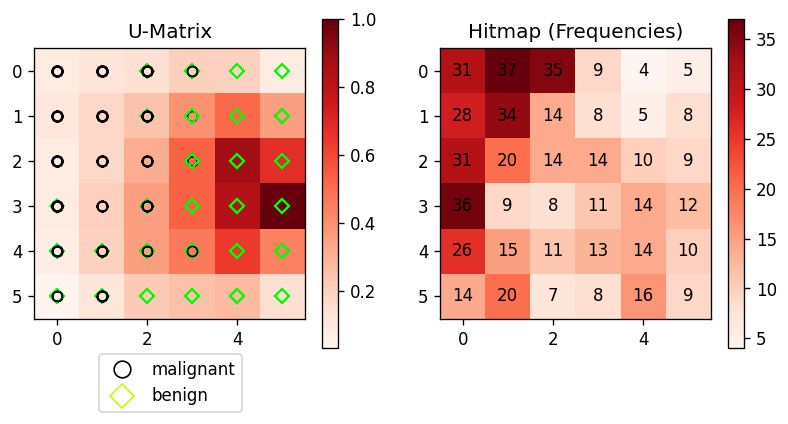

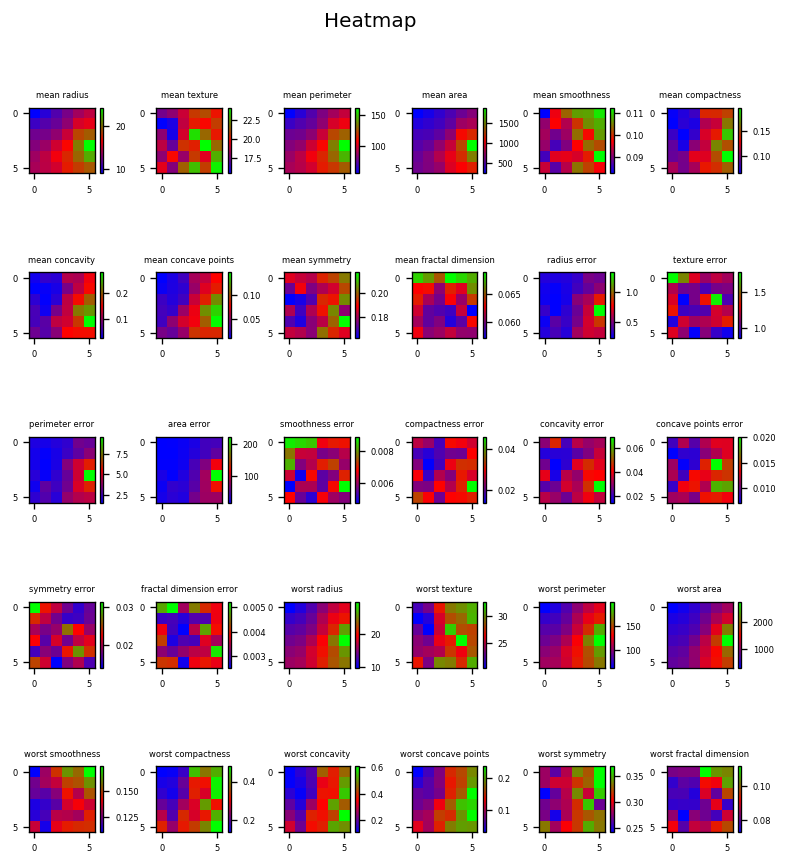

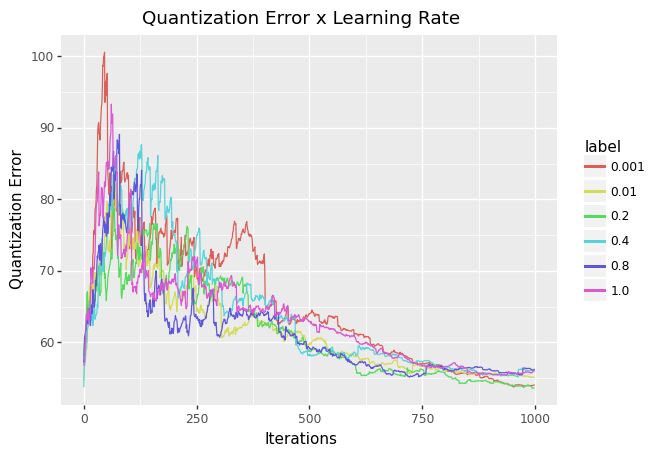

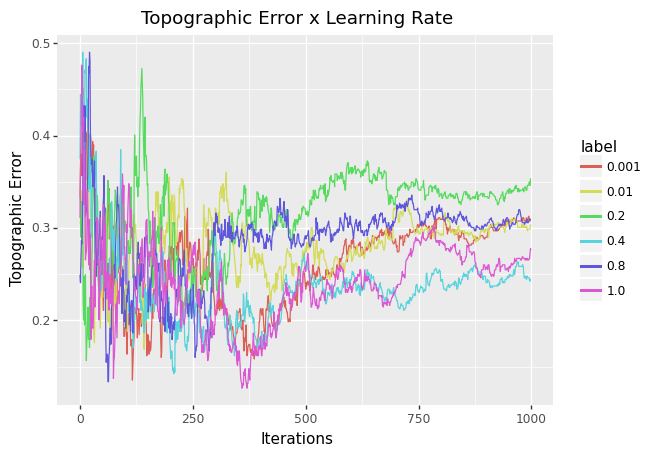

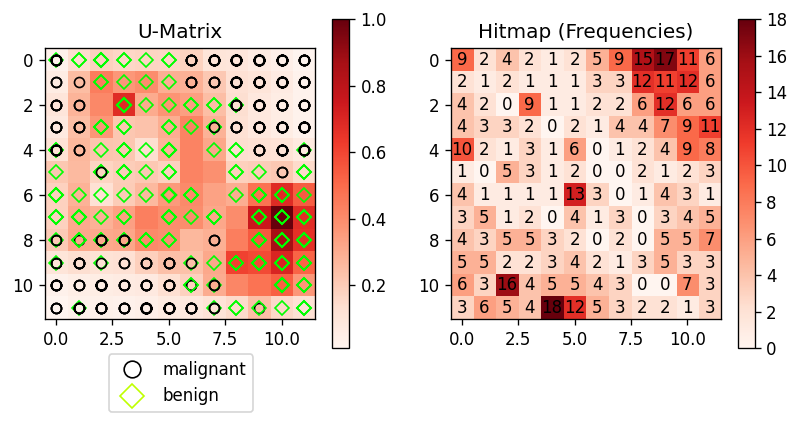

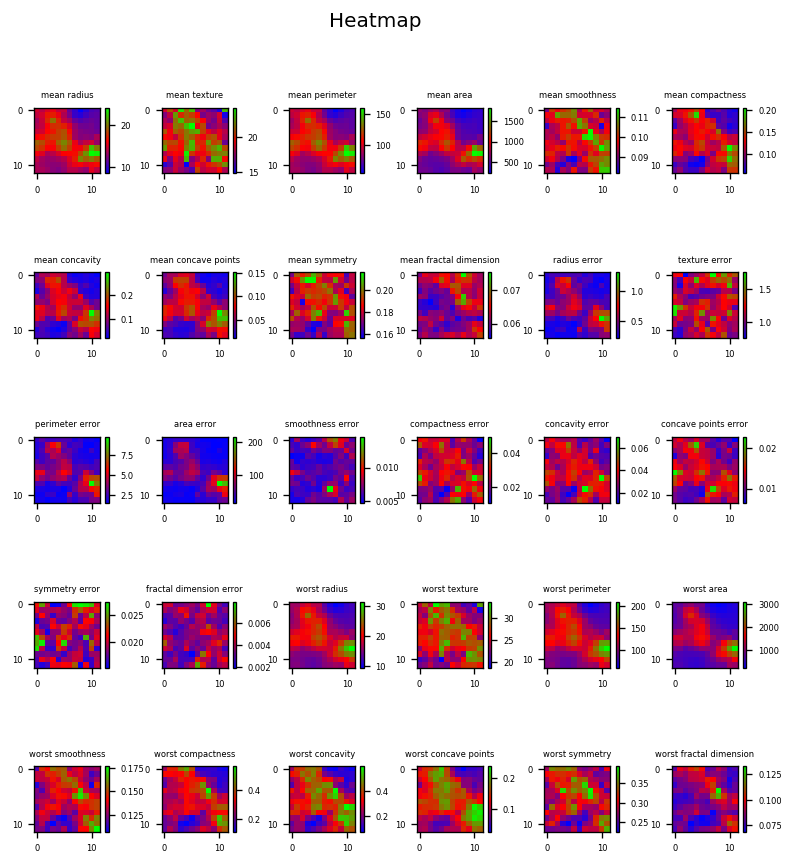

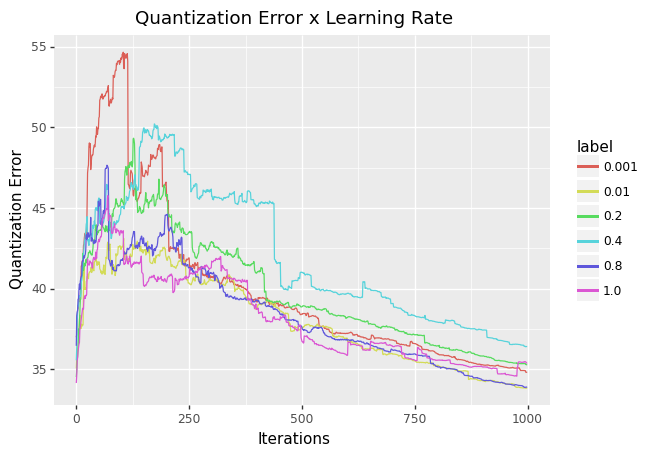

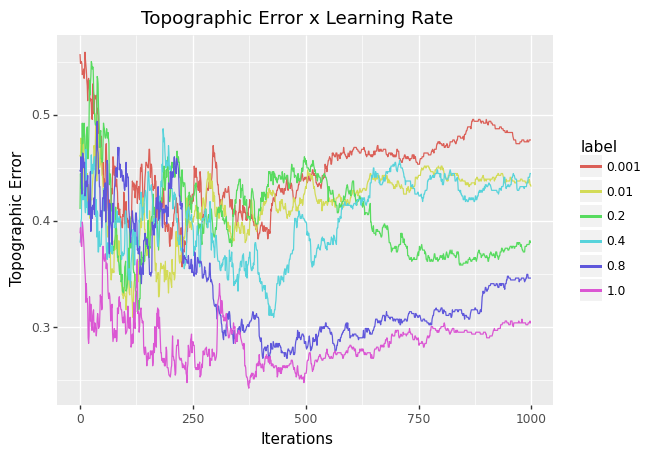

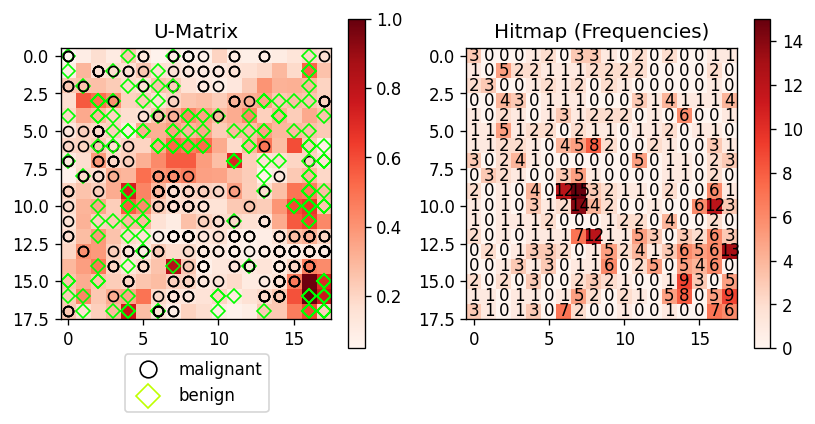

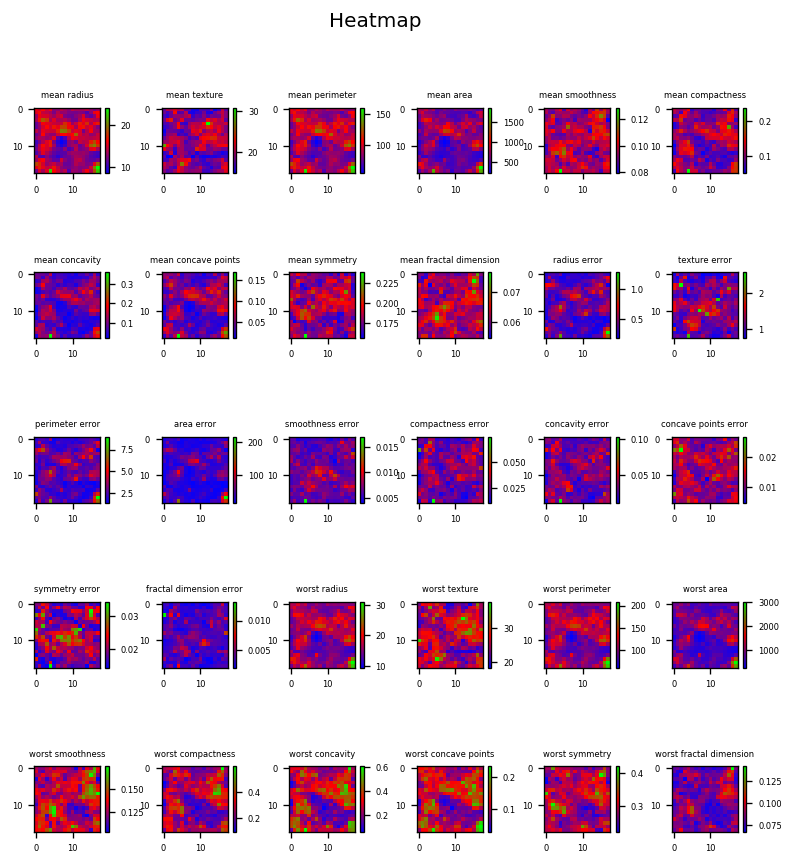

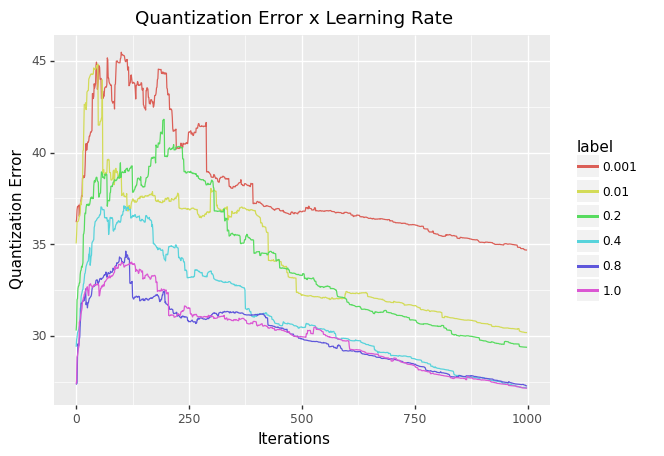

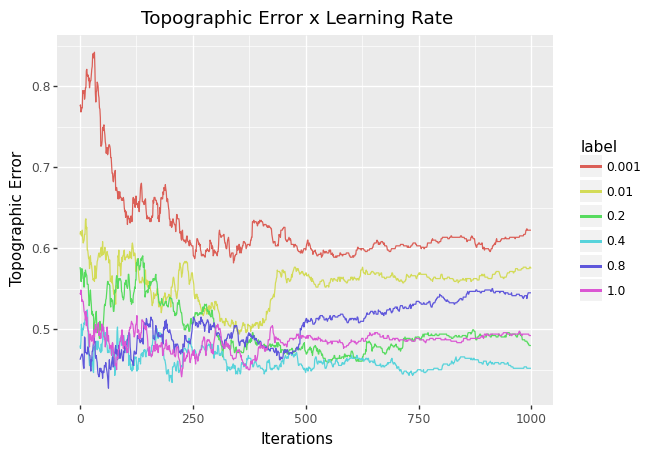

In [89]:
# install miniSOM python lib
!pip install minisom

from minisom import MiniSom

colors = ['black', 'dodgerblue', 'lime']
markers = ['o', 's', 'D']

breast_cancer_dimension = 30 # Number of input attributes from breast cancer dataset

for g in grid:
    som = MiniSom(x=g, y=g, input_len=breast_cancer_dimension, random_seed=RANDOM_STATE)
    som.random_weights_init(breast_cancer.data)
    som.train_random(breast_cancer.data, number_of_epochs)

    plot_som_maps(som, breast_cancer, 5, 6, breast_cancer.target, colors, markers, breast_cancer.target_names, dpi=120, figsize=(8, 8))
    plot_learning_rate(som, lr, breast_cancer.data, g, 30)

## Trainamento da Rede SOM - *Dataset* `Iris`

A seguir apresentamos o código o treinamento e avaliação de desempenho da rede SOM, utilizando o dataset `iris`, em diversas configurações.

### Grade 6x6

Com a grade 6 x 6, temos resultados um pouco confusos em relação à distribuição das classes pelos neurônios. Na *U-Matrix* ficou evidente a confusão entre as classes `setosa` e  `versicolor`, devido ao fato da grade não ter espaço suficiente para melhor delineamento dos *clusters*. No caso do *Hitmap*, foi mostrado um pouco a separação de 3 *clusters* pelas frequências 0, 1 e 2.

Comparando os *Heatmaps* com a *U-Matrix*, `sepal width` apresentou um valor mais acentuado para o tipo `virginica`, mas acabou gerando um pouco de confusão com valores parecidos para `setosa` e `versicolor`. As outras caraterísticas destacaram bem a faixa de valores para cada uma das espécies, havendo apenas um pouco de confusão em relação à `virginica` e `versicolor` em `sepal length`.

O erro topográfico apresentou uma variação muito alta em relação à taxa de aprendizagem. Isso é devido provavelmente ao tamanho da grade em relação à quantidade exemplos avaliados. Aparentemente a taxa de aprendizagem `0.4` apresentou o melhor decaimento no erro de quantização, enquanto a taxa `1.0` apresentou o melhor decaimento para o erro topográfico no fim do treinamento.

### Grade 12x12
Com a grade 12 x 12, temos uma melhor separação dos clusters, como mostrado pela *U-Matrix* e também houve um aumento em seu número, como mostrado pelo Hitmap.

Novamente, houve grande confusão entre as classes `versicolor` e `setosa` em relação ao atributo `sepal width` acrescentando dessa vez a `virginica`. 

O erro topográfico, apesar de suavizado, ainda apresentou uma variação muito alta em relação à taxa de aprendizagem. Aparentemente a taxa de aprendizagem `0.4` apresentou o melhor decaimento no erro de quantização, enquanto a taxa `1.0` apresentou o melhor decaimento para o erro topográfico no fim do treinamento.

### Grade 18x18

Com a grade 18 x 18, houve ainda uma melhor dispersão dos clusters, apesar de alguns pontos possuírem confusão entre `setosa` e `versicolor`, como mostrado pela *U-Matrix*. Houve um aumento no número de clusters e sua distribuição, como mostrado pelo *Hitmap*.

A confusão entre as classes `versicolor`, `setosa` e `virginica` em relação ao atributo `sepal width` ficou mais evidente na grade 18 x 18.

Ficou bem mais fácil visualizar o erro topográfico. Aparentemente a taxa de aprendizagem `1.0` apresentou o melhor decaimento no erro de quantização e também para o erro topográfico.

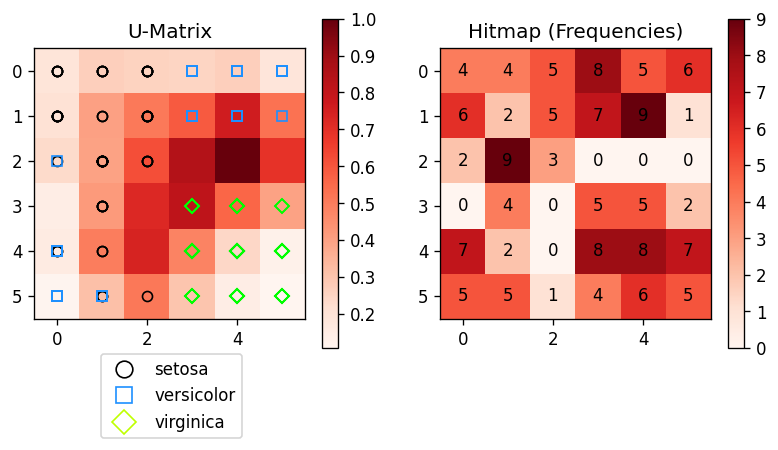

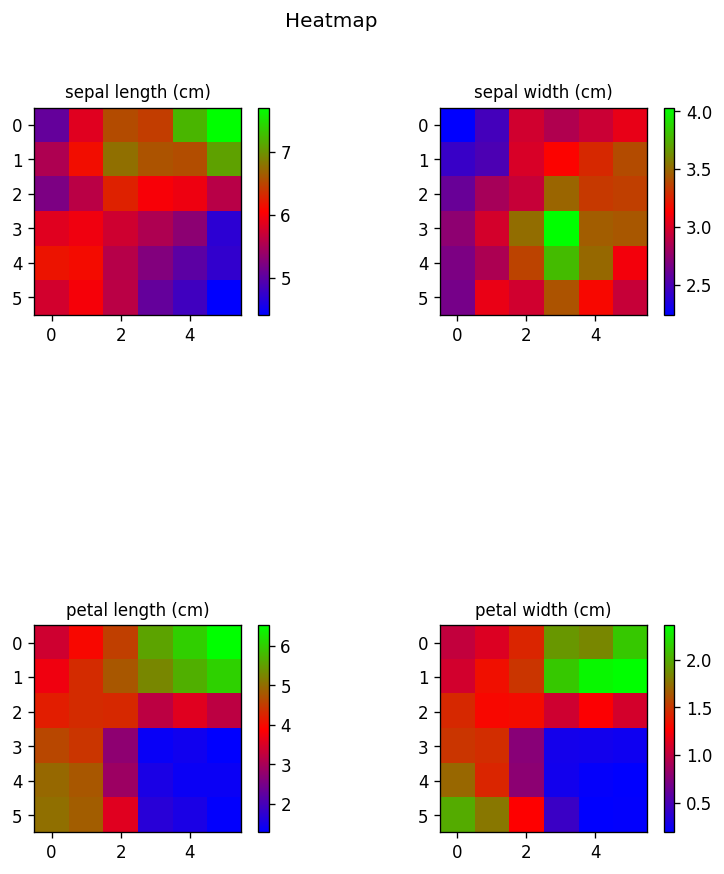

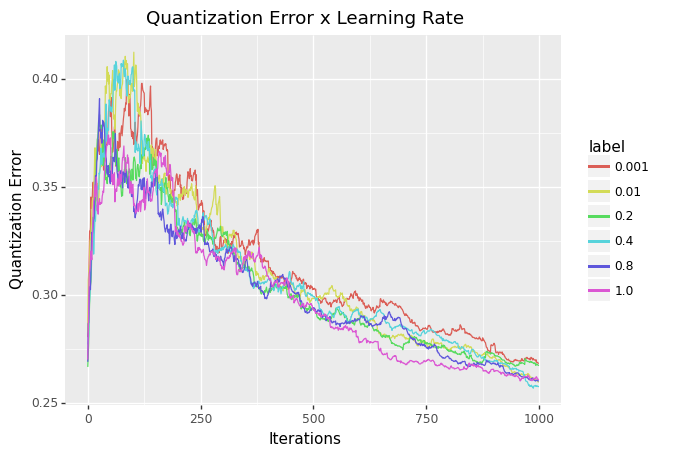

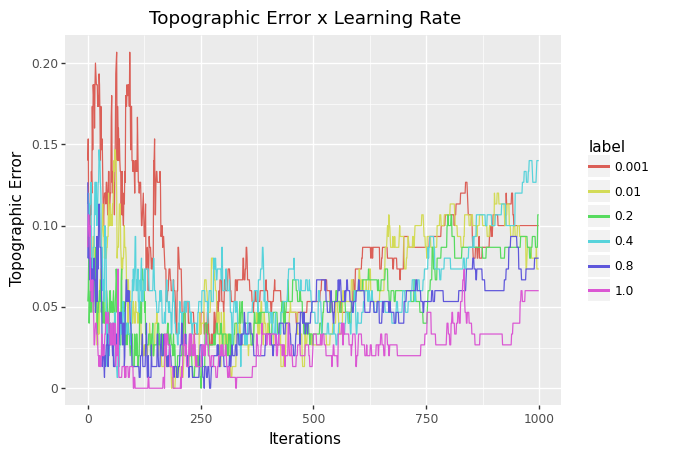

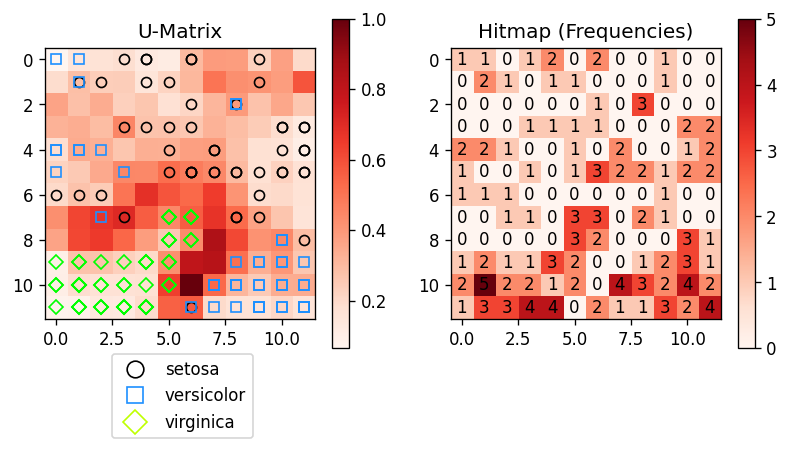

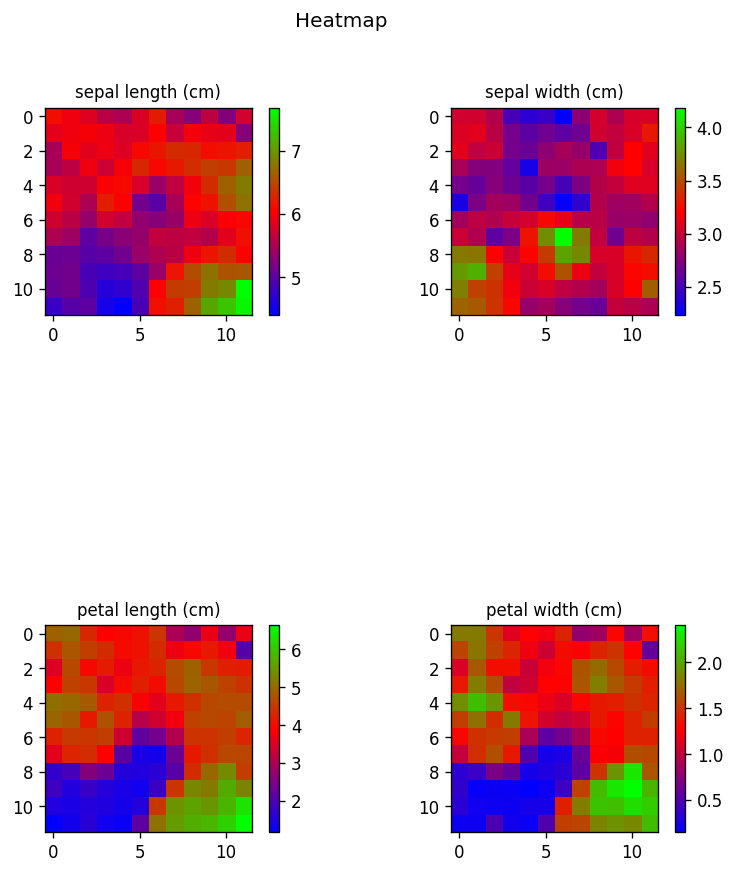

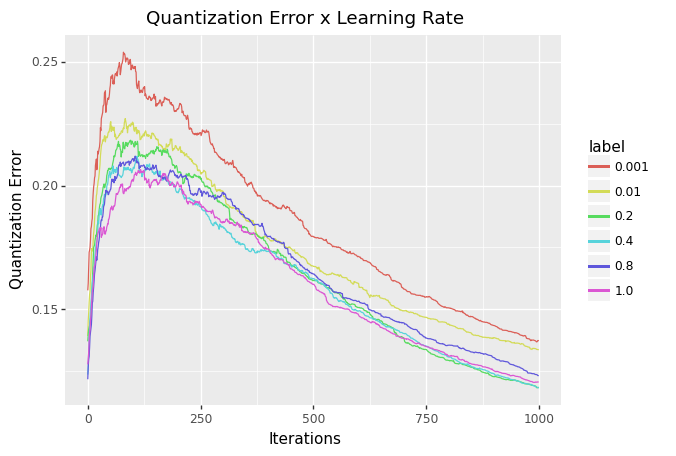

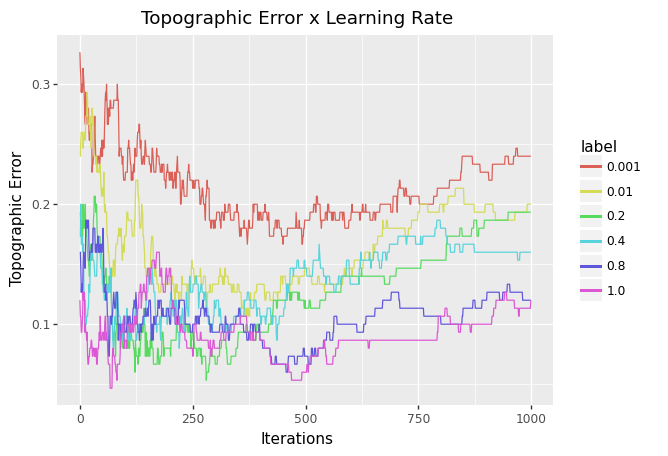

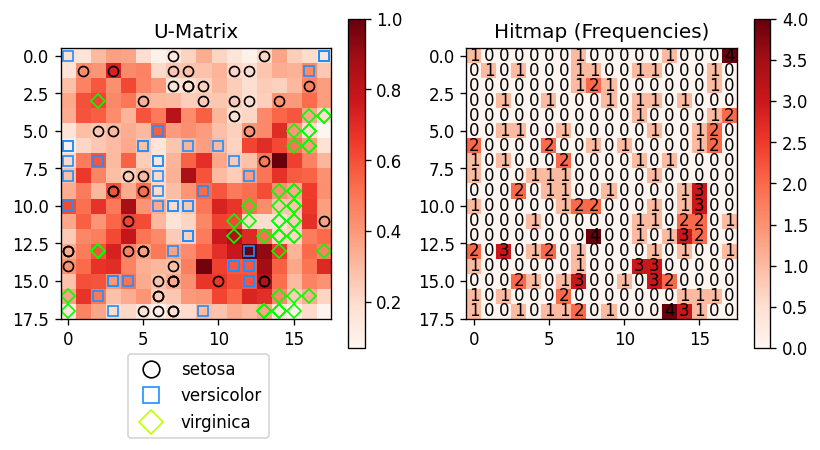

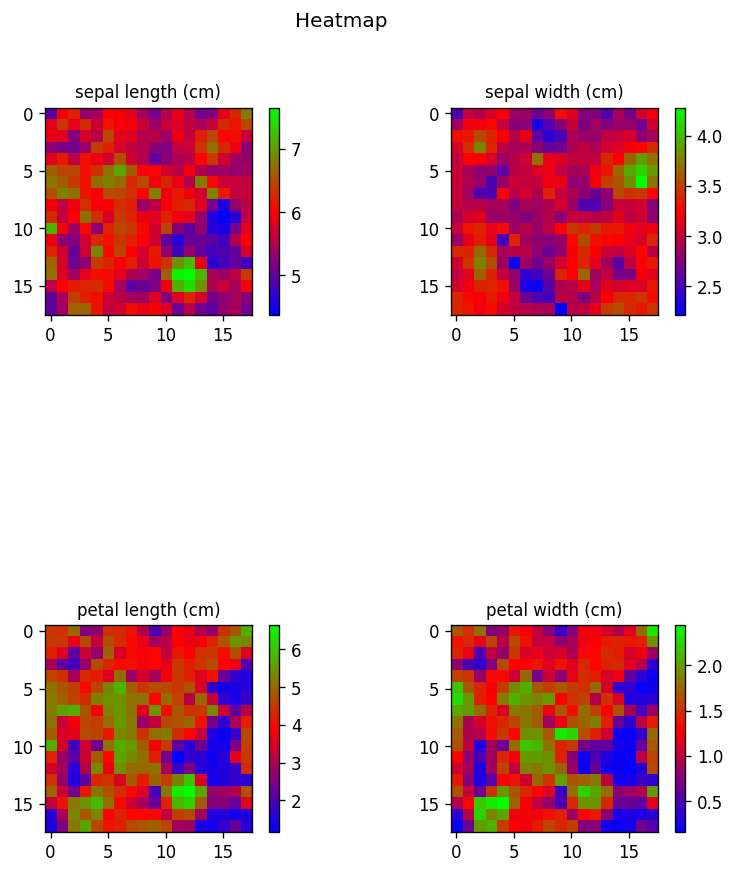

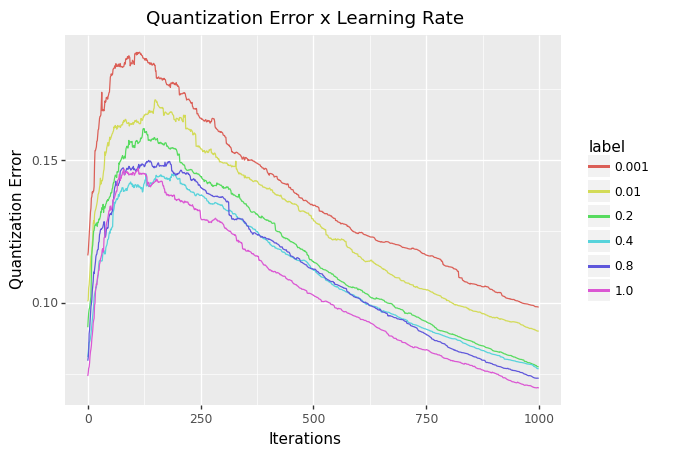

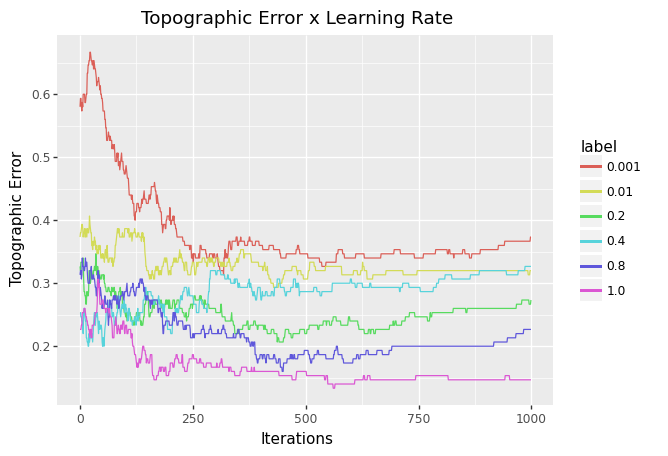

In [90]:
iris_dimension = 4 # Number of input attributes from iris dataset

for g in grid:
    som = MiniSom(x=g, y=g, input_len=iris_dimension, random_seed = RANDOM_STATE)
    som.random_weights_init(iris.data)
    som.train_random(iris.data, number_of_epochs)

    plot_som_maps(som, iris, 2, 2, iris.target, colors, markers, iris.target_names, dpi=120, figsize=(8, 8))
    plot_learning_rate(som, lr, iris.data, g, 4)

## Trainamento da Rede SOM - *Dataset* `Wine`

A seguir apresentamos o código o treinamento e avaliação de desempenho da rede SOM, utilizando o dataset `wine`, em diversas configurações.

### Grade 6x6

Com a grade 6 x 6, temos resultados bem confusos entre todas as classes representadas pela *U-Matrix* aglomerando os clusters. No caso do *Hitmap*, foi mostrado pouco presença de frequências 0 e 1, tornando difícil a separação dos *clusters* somente com as frequências 2.

Comparando os Heatmaps com a *U-Matrix*, os atributos `flavanoids`, `nonflavanoid_phenols` e `total_phenols` apresentaram resultados mais aproximados da distribuição das classes de vinhos. Entretanto, houve grande confusão em outras atributos, como `ash`, `color_intensity` e `hue`.

O erro topográfico apresentou uma variação muito alta em relação à taxa de aprendizagem. Isso é devido provavelmente ao tamanho da grade em relação à quantidade exemplos avaliados. Aparentemente as taxas de aprendizagem `1.0` e `0.8` apresentaram o melhor decaimento para o erro de quantização, enquanto a taxa `0.8` apreentou o melhor decaimento para o erro topográfico.

### Grade 12x12

Com a grade 12 x 12, pela *U-Matrix* temos resultados bem confusos entre as classes `class_0` e `class_1`, mas houve melhor distribuição da `class_2`. No caso do *Hitmap*, foi apresentado melhor delineamento de novos clusters, facilitando um pouco o agrupamento dos dados.

No caso dos Heatmaps com a *U-Matrix*, os atributos apresentaram uma distribuição um pouco mais satisfatória, mas ainda houve grande confusão, principalmente entre as `classes class_0` e `class_1`.

O erro topográfico, apesar de suavizado, ainda apresentou uma variação muito alta em relação à taxa de aprendizagem. Aparentemente as taxas de aprendizagem `0.01` e `1.0` apresentaram o melhor decaimento para o erro de quantização, enquanto a taxa `0.8` apreentou o melhor decaimento para o erro topográfico.

### Grade 18x18

Com a grade 18 x 18, houve uma grande melhora na dispersão das classes `class_0`, `class_1` e `class_2`, com poucos pontos confusos. No caso do *Hitmap*, os clusters ficaram muito mais definidos.

Nos *Heatmaps*, houve uma piora na confusão de certos atributos como `ash` e `magnesium`. Isso é provavelmente devido ao fato de termos novos *clusters* menores espalhados pelo espaço de dados.

O erro topográfico ainda apresentou uma variação muito alta em relação à taxa de aprendizagem. Aparentemente a taxa de aprendizagem `0.4` apresentou o melhor decaimento para o erro de quantização, enquanto a taxa `0.8` apreentou o melhor decaimento para o erro topográfico.

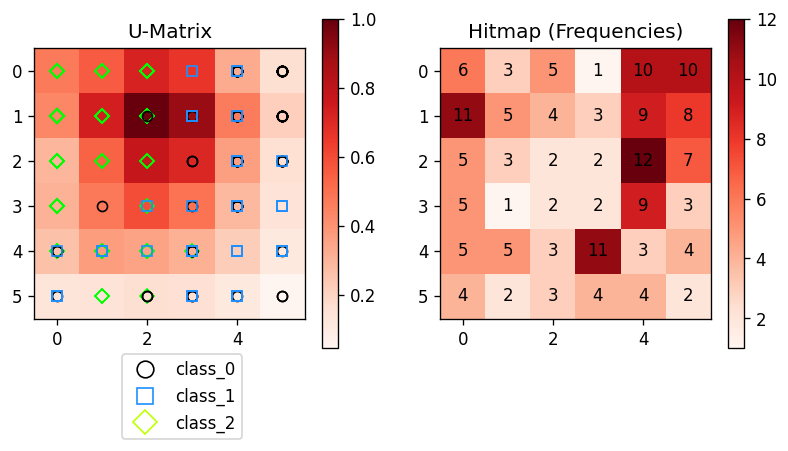

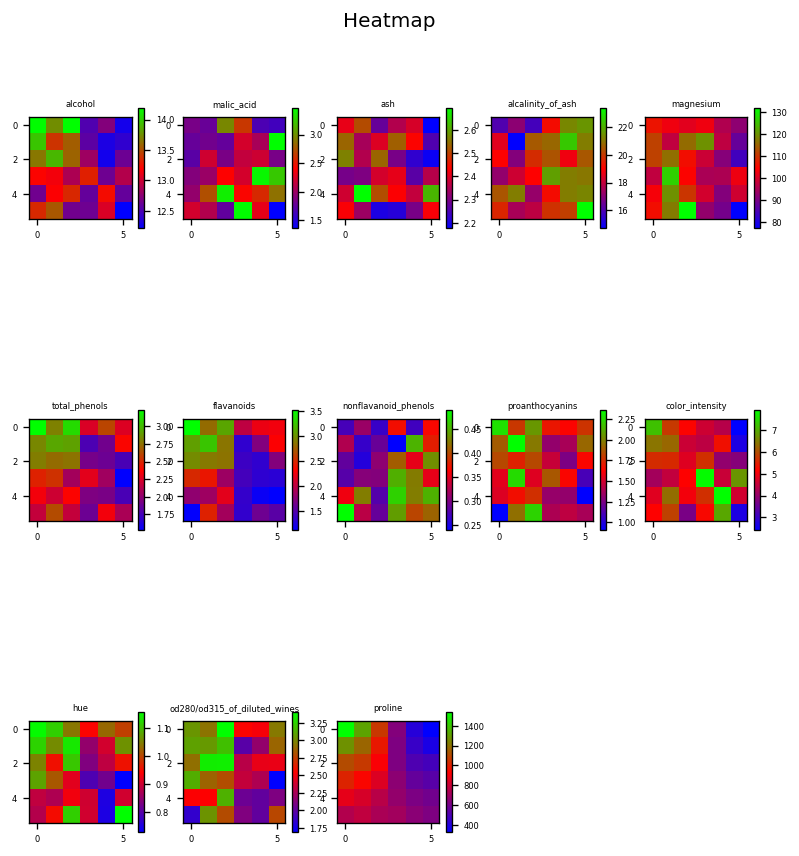

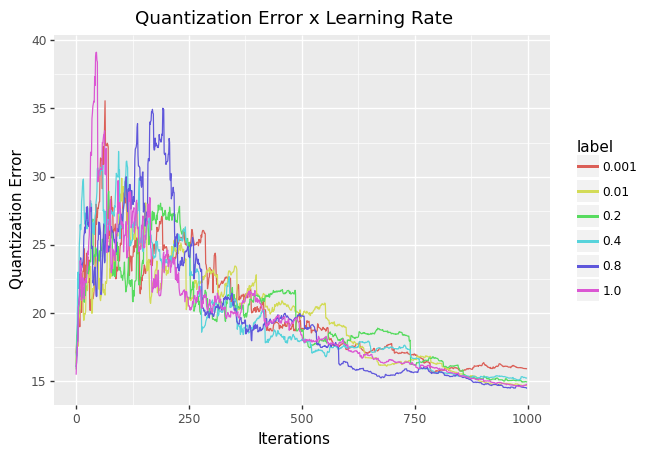

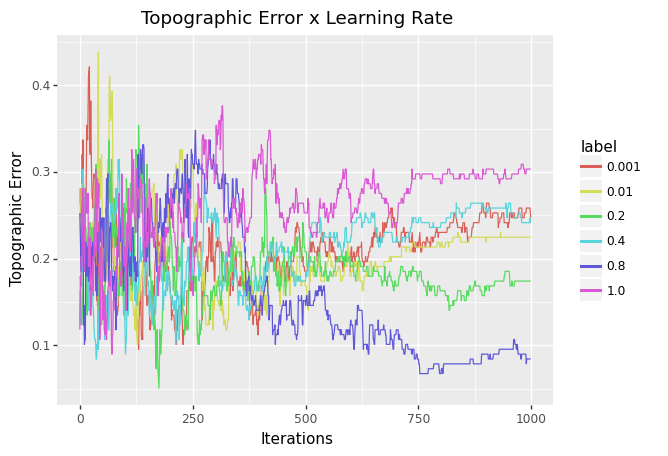

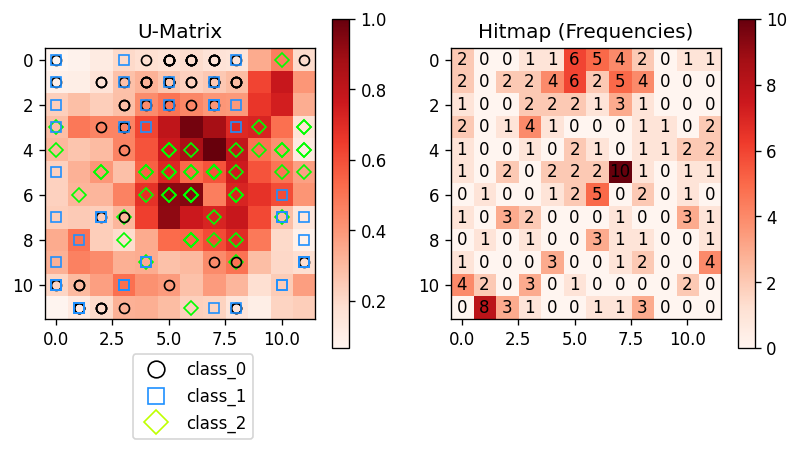

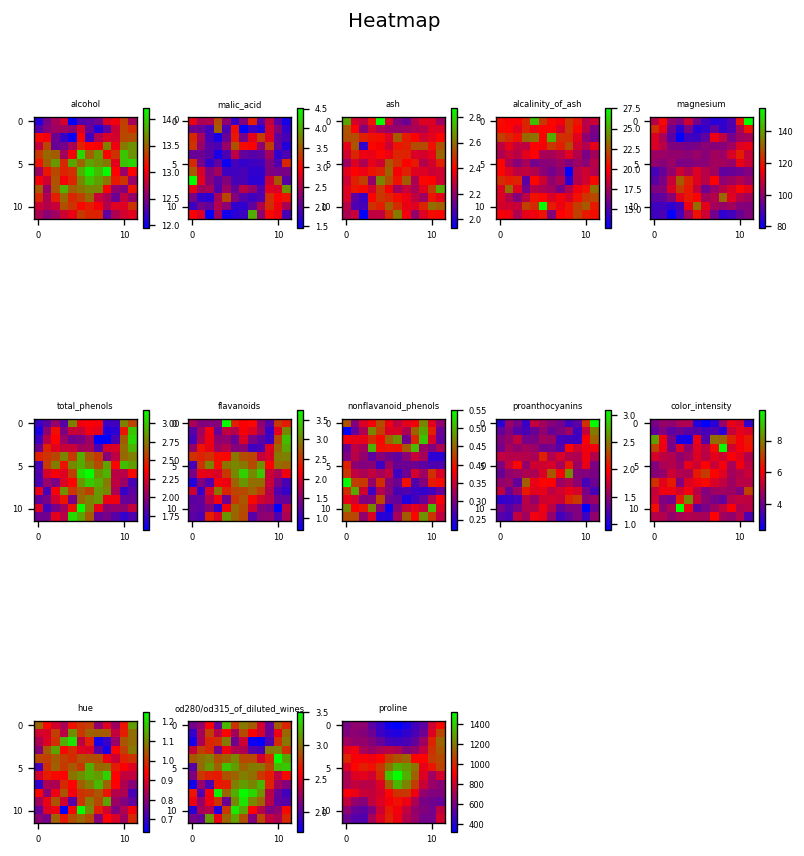

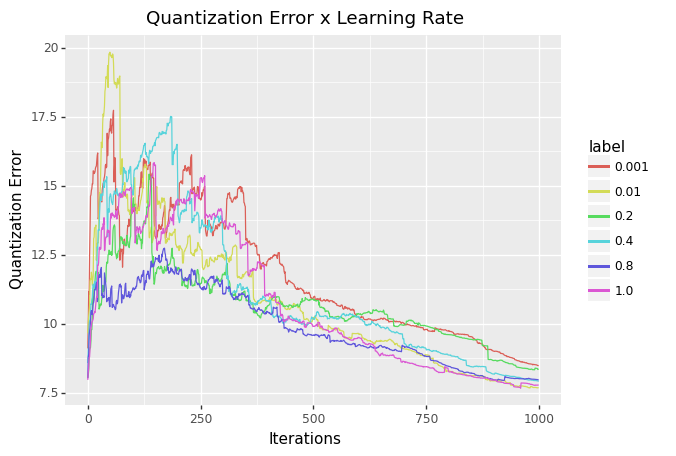

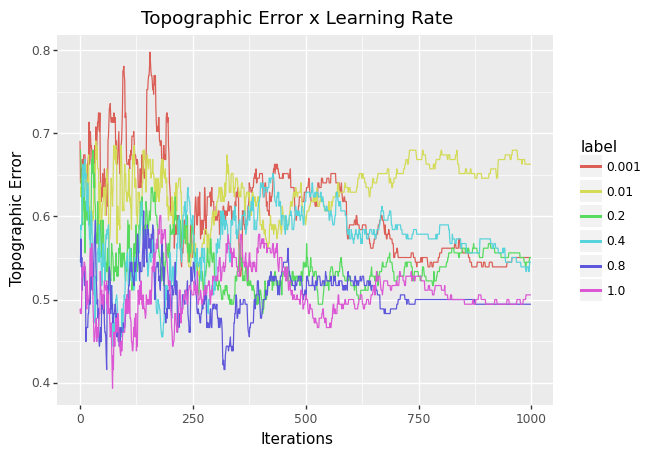

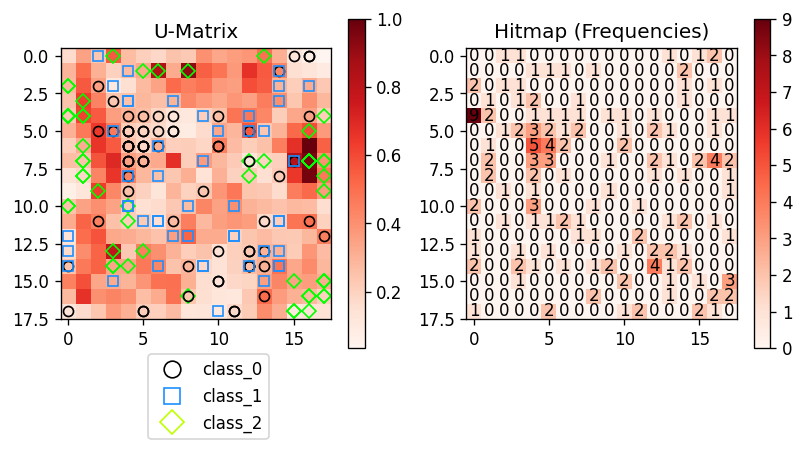

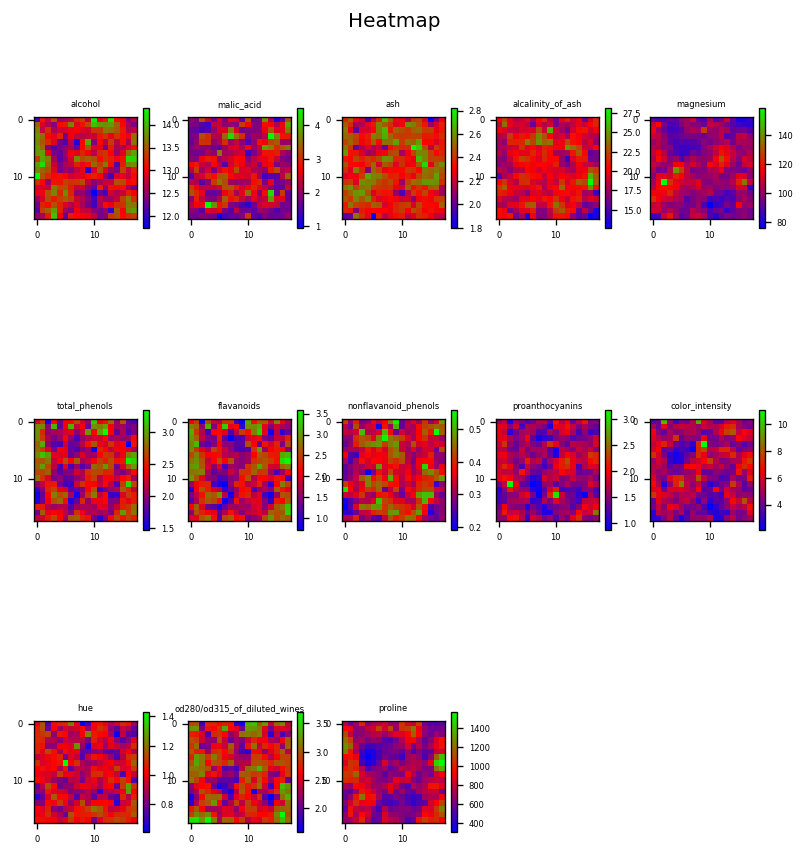

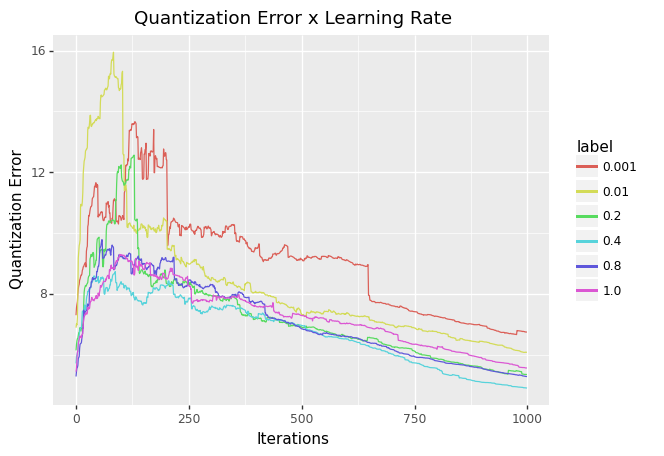

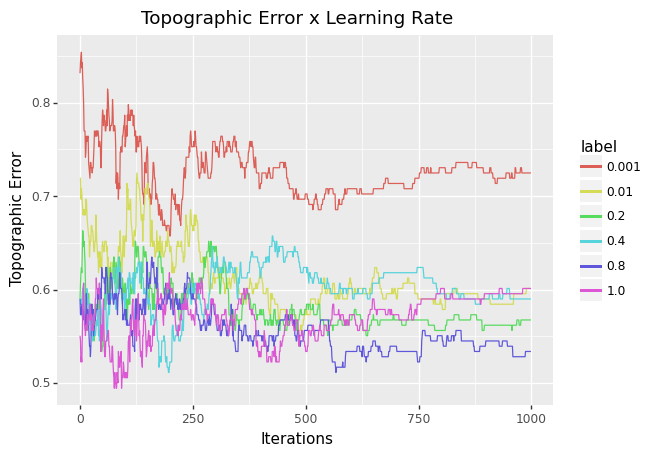

In [91]:
wine_dimension = 13 # Number of input attributes from wine dataset

for g in grid:
    som = MiniSom(x=g, y=g, input_len=wine_dimension, random_seed=RANDOM_STATE)
    som.random_weights_init(wine.data)
    som.train_random(wine.data, number_of_epochs)

    plot_som_maps(som, wine, 3, 5, wine.target, colors, markers, wine.target_names, dpi=120, figsize=(8, 8))
    plot_learning_rate(som, lr, wine.data, g, wine_dimension)